In [1]:
a = (2,3,4)
print(len(a))

3


In [2]:
# Params
input_size = (299,299)
batch_size = 100
num_workers = 4
learning_rate = 1e-03
momentum = 0.9
epochs = 1

# Training an image classifier

In [3]:
import torch

print("torch-version:", torch.__version__)
print("Available GPU:", torch.cuda.current_device())

torch-version: 1.1.0
Available GPU: 0


## 1. Loading and normalizing CIFAR10

In [4]:
import torchvision
import torchvision.transforms as transforms

In [5]:
transform = transforms.Compose(
    [transforms.Resize(input_size), # Must be ahead of transforms.ToTensor()
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print()
print(trainset.__getitem__(0)[0].size(), trainset.__len__())
print(testset.__getitem__(0)[0].size(), testset.__len__())

Files already downloaded and verified
Files already downloaded and verified

torch.Size([3, 299, 299]) 50000
torch.Size([3, 299, 299]) 10000


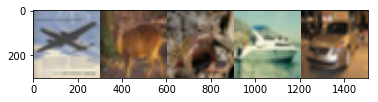

plane  deer  frog  ship   car


In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:5]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

## 2. Define a Inception net

### Important: In contrast to the other models the inception_v3 expects tensors with a size of N x 3 x 299 x 299, so ensure your images are sized accordingly.

In [7]:
import torchvision
print("torchvision-version:", torchvision.__version__)

net = torchvision.models.inception_v3(pretrained=False, aux_logits=True).cuda()

torchvision-version: 0.2.2


In [8]:
param_list = list(net.children())
print(param_list)

[BasicConv2d(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
), BasicConv2d(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
), BasicConv2d(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
), BasicConv2d(
  (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
), BasicConv2d(
  (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
), InceptionA(
  (branch1x1): BasicConv2d(
    (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1),

## 3. Define a Loss function and optimizer

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

## 4. Train the network

In [10]:
times = 1

for epoch in range(epochs):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, aux_outputs = net(inputs)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        
        loss = loss1 + 0.4*loss2
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if epoch % times == 0:
        print('[%d] loss: %.3f' %(epoch, running_loss / times))
        running_loss = 0.0
        #torch.save(model,'./data/cifar_model.pkl')

print('\nFinished Training')

[0] loss: 2136.009

Finished Training


## 5. Test the network on the test data

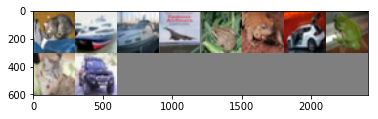

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car
Predicted:    cat   car  ship plane  bird  frog truck  frog   cat   car


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:10]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

# Predicted
cpu_net = net.cpu().eval()
outputs = cpu_net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(10)))

In [13]:
correct = 0
total = 0

with torch.no_grad():
    cpu_net.eval()
    for data in testloader:
        images, labels = data
        images = images.cpu()
        labels = labels.cpu()
        
        outputs = cpu_net(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' %(100 * correct / total))

Accuracy of the network on the 10000 test images: 34 %
